In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from tqdm.notebook import tqdm
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


import lightgbm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import scale
from sklearn.linear_model import SGDClassifier

%matplotlib inline 

pd.options.mode.chained_assignment = None


from sklearn.utils import resample



# Importing gc module 
import gc 

### Featurized data is loaded Here and splitted into train and test data

In [2]:
feature_data = pd.read_csv('feature_data').drop(['Unnamed: 0'],axis=1)
#test_data =  pd.read_csv('feature_data_test.csv')

In [4]:
feature_data.shape

(8474661, 79)

### Train Test Splitting

In [3]:
#for final model
y_train=feature_data.iloc[0:5932188]['reordered']
train_users=feature_data.iloc[0:5932188]['user_id']
x_train=feature_data.iloc[0:5932188].drop(['reordered','user_id','product_id'],axis = 1)

In [4]:
y_test=feature_data.iloc[5932188:]['reordered']
test_users=feature_data.iloc[5932188:]['user_id']
x_test=feature_data.iloc[5932188:].drop(['reordered','user_id','product_id'],axis = 1)

In [5]:
pred_true_data=feature_data.iloc[5932188:][['user_id','product_id','reordered']]
master_train=pd.read_csv('master_train.csv')
pred_true_data=pd.merge(pred_true_data,master_train[['user_id','order_id']].drop_duplicates(),on=['user_id'],how='inner')
pred_true_data['y_true']=pred_true_data['reordered']
pred_true_data.drop(['reordered'],axis=1,inplace=True)

In [5]:
pred_true_data=pd.read_csv('pred_true_data.csv')

### MODELING

<AxesSubplot:>

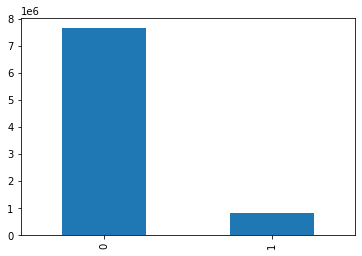

In [16]:
feature_data['reordered'].value_counts().plot(kind='bar')

##### Looks like class is imbalanced we will try to take care of it 

In [17]:
feature_data['reordered'].value_counts()

0    7645837
1     828824
Name: reordered, dtype: int64

### common functions

#### The below function measures micro and macro F1 score when probability estimates are given

In [38]:
def measure_best_F1_score(y_pred_proba):
    y_pred=[]
    for j in range(len(y_pred_proba)):
        if(y_pred_proba[j][1]>0.2):
            y_pred.append(1)
        else:
            y_pred.append(0)
    pred_true_data['y_pred']=y_pred
    temp_test_order_id=pd.unique(pred_true_data['order_id'])
    f_test_products=dict()
    f_pred_products=dict()
    for oid in tqdm(temp_test_order_id):
        temp_data=pred_true_data[pred_true_data['order_id']==oid]
        temp_true=temp_data[temp_data['y_true']==1]['product_id'].tolist()
        if temp_true:
            f_test_products[oid] = temp_true
        else:
            f_test_products[oid]=['None']
        temp_pred=temp_data[temp_data['y_pred']==1]['product_id'].tolist()
        if temp_pred:
            f_pred_products[oid]=temp_pred
        else:
            f_pred_products[oid]=["None"]
    
    f_score=[]
    for key in tqdm(f_test_products):
        f_score.append(multilabel_fscore(f_test_products[key],f_pred_products[key]))
    mean_micro_f1_score=np.mean(f_score)
    for_macro_score=[]
    for i in f_test_products.values():
        for_macro_score.append(len(i))
    score_len=zip(f_score,for_macro_score)
    temp=0
    for score,length in score_len:
        temp+=score*length
    macro_f1_score=temp/sum(for_macro_score)
    return mean_micro_f1_score,macro_f1_score
        

#### The below function Calucates multilabel F1_score which will be user in our previous function
#### credits https://www.kaggle.com/onodera/multilabel-fscore

In [8]:
def multilabel_fscore(y_true, y_pred):
    """
    ex1:
    y_true = [1, 2, 3]
    y_pred = [2, 3]
    return: 0.8
    
    ex2:
    y_true = ["None"]
    y_pred = [2, "None"]
    return: 0.666
    
    ex3:
    y_true = [4, 5, 6, 7]
    y_pred = [2, 4, 8, 9]
    return: 0.25
    
    """
    y_true, y_pred = set(y_true), set(y_pred)
    
    precision = sum([1 for i in y_pred if i in y_true]) / len(y_pred)
    
    recall = sum([1 for i in y_true if i in y_pred]) / len(y_true)
    
    if precision + recall == 0:
        return 0
    return (2 * precision * recall) / (precision + recall)


#### The F1 score maximization technique. Specifically designed for kaggle competion. Not be applicable in the real world

##### credits https://www.kaggle.com/mmueller/f1-score-expectation-maximization-in-o-n/

In [3]:
# -*- coding: utf-8 -*-
"""
@author: Faron
"""
import numpy as np
from operator import itemgetter

'''
This kernel implements the O(n²) F1-Score expectation maximization algorithm presented in
"Ye, N., Chai, K., Lee, W., and Chieu, H.  Optimizing F-measures: A Tale of Two Approaches. In ICML, 2012."

'''


class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        
        P = np.sort(P)[::-1]
       
        n = np.array(P).shape[0]
        
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]
        

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(k + 1):
                
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])
        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        
        max_f1 = expectations[ix_max]

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone, max_f1

    

def get_best_prediction(items, preds, pNone=None):
#    print("Maximize F1-Expectation")
#    print("=" * 23)
    items_preds = sorted(list(zip(items, preds)), key=itemgetter(1), reverse=True)
    P = [p for i,p in items_preds]
    L = [i for i,p in items_preds]
    
    opt = F1Optimizer.maximize_expectation(P, pNone)
   
    best_prediction = ['None'] if opt[1] else []
    
    best_prediction += (L[:opt[0]])
   
#    f1_max = opt[2]
    
#    print("Prediction {} yields best E[F1] of {}\n".format(best_prediction, f1_max))
    return ' '.join(list(map(str,best_prediction)))

if __name__ == '__main__':
    get_best_prediction(['a', 'b'], [0.01, 0.1],0.6)

##### logistic regresssion with SGD classifier

###### data is scaled below as logistic regression,linear svm ,naive baye's  work better with normalized or scaled data
###### Data is balance with class_weight='balanced' parameter in SGD classifier

In [6]:
x_train=scale(x_train,axis=0)
x_test=scale(x_test,axis=0)

In [9]:
alpha = [10 ** x for x in range(-5, 1)] 
f1_scores_logistic=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight='balanced',n_jobs=-1)
    #Here we have taken care of imbalanced dataset.
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    micro_f1_score,macro_f1_score = measure_best_F1_score(predict_y)
    f1_scores_logistic.append([alpha,micro_f1_score,macro_f1_score])
np.save('f1_scores_logistic.npy',f1_scores_logistic)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [43]:
f1_scores_logistic=np.load('f1_scores_logistic.npy',allow_pickle=True)
print('for hyper parameter alpha={},'.format(0.001))
print('logistic regression best micro f1 score is {}'.format(np.round(f1_scores_logistic[2][1],4)))
print('logistic regression best macro f1 score is {}'.format(np.round(f1_scores_logistic[2][2],4)))

for hyper parameter alpha=0.001,
logistic regression best micro f1 score is 0.3714
logistic regression best macro f1 score is 0.438


##### SVM with SGD classifier

In [10]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

f1_scores_svm=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42,class_weight='balanced',n_jobs=-1)
    clf.fit(x_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    
    micro_f1_score,macro_f1_score = measure_best_F1_score(predict_y)
    f1_scores_svm.append([alpha,micro_f1_score,macro_f1_score])
np.save('f1_scores_svm.npy',f1_scores_svm)




  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [35]:
f1_scores_svm=np.load('f1_scores_svm.npy',allow_pickle=True)
print('for hyper parameter alpha={},'.format(0.00001))
print('linear svm best micro f1 score is {}'.format(np.round(f1_scores_svm[0][1],4)))
print('linear svm best macro f1 score is {}'.format(np.round(f1_scores_svm[0][2],4)))

for hyper parameter alpha=1e-05,
linear svm best micro f1 score is 0.3674
linear svm best macro f1 score is 0.4452


#### Naive_baye's method

In [166]:
train_users=feature_data.iloc[0:5932188]['user_id']
x_train=feature_data.iloc[0:5932188].drop(['user_id','product_id'],axis = 1)

x_train_majority=x_train[x_train.reordered==0]
x_train_minority=x_train[x_train.reordered==1]

#https://elitedatascience.com/imbalanced-classes
#### Upsample minority class
x_train_minority_upsampled = resample(x_train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=5352199,    # to match majority class
                                 random_state=123)
x_train = pd.concat([x_train_majority, x_train_minority_upsampled])

del x_train_majority,x_train_minority,x_train_minority_upsampled,feature_data,master_train

#https://www.geeksforgeeks.org/garbage-collection-python/
collected = gc.collect() 
print("Garbage collector: collected", 
          "%d objects." % collected) 

y_train=x_train['reordered']
x_train.drop(['reordered'],axis=1,inplace=True)

x_train=scale(x_train,axis=0)
x_test=scale(x_test,axis=0)

Garbage collector: collected 0 objects.


In [16]:
Parameter_list=[1e-9,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]

f1_scores_naive=[]
for alpha in tqdm(Parameter_list):
    GB = GaussianNB(var_smoothing=alpha)
    GB.fit(x_train, y_train)
    y_predict_proba=GB.predict_proba(x_test)
    micro_f1_score,macro_f1_score = measure_best_F1_score(y_predict_proba)
    f1_scores_naive.append([alpha,micro_f1_score,macro_f1_score])
f1_scores_naive = np.array(f1_scores_naive)
np.save('f1_scores_naive.npy',f1_scores_naive)

  0%|          | 0/8 [00:00<?, ?it/s]

##### Naive Baye's method with calibration

In [169]:
Parameter_list=[1]

f1_scores_naive=[]
for alpha in tqdm(Parameter_list):
    GB = GaussianNB(var_smoothing=alpha)
    GB.fit(x_train, y_train)
    cab_clf = CalibratedClassifierCV(GB, method="sigmoid")
    cab_clf.fit(x_train, y_train)
    y_predict_proba=cab_clf.predict_proba(x_test)
    micro_f1_score,macro_f1_score = measure_best_F1_score(y_predict_proba)
    f1_scores_naive.append([alpha,micro_f1_score,macro_f1_score])
f1_scores_naive = np.array(f1_scores_naive)
np.save('f1_scores_naive_calibrated.npy',f1_scores_naive)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

In [39]:
f1_scores_naive=np.load('f1_scores_naive.npy',allow_pickle=True)
print('for variable smoothing hyper parameter ={},'.format(1))
print('naive baye\'s best micro f1 score is {}'.format(np.round(f1_scores_naive[5][1],4)))
print('naive baye\'s best macro f1 score is {}'.format(np.round(f1_scores_naive[5][2],4)))

for variable smoothing hyper parameter =1,
naive baye's best micro f1 score is 0.3092
naive baye's best macro f1 score is 0.3997


In [170]:
f1_scores_naive

array([[1.        , 0.21508982, 0.27130971]])

##### Random Forest(bagging)

In [8]:
R_cfl=RandomForestClassifier(n_jobs=-1)

prams={
    
     'n_estimators':[10,50,100,500],
     'max_depth':[3,5,10],
    'min_samples_split':[2,4,8],
    'min_samples_leaf':[1,2,4,6]
}
random_cfl=RandomizedSearchCV(R_cfl,param_distributions=prams,verbose=10,scoring='neg_log_loss',)
random_cfl.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=500
[CV 1/5; 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=11.0min
[CV 2/5; 1/10] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=500
[CV 2/5; 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=10.7min
[CV 3/5; 1/10] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=500
[CV 3/5; 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=10.7min
[CV 4/5; 1/10] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=500
[CV 4/5; 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=10.8min
[CV 5/5; 1/10] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=500
[CV 5/5; 1/10] END max_depth=5, min_sam

[CV 1/5; 9/10] END max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time= 2.3min
[CV 2/5; 9/10] START max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=100
[CV 2/5; 9/10] END max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time= 2.3min
[CV 3/5; 9/10] START max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=100
[CV 3/5; 9/10] END max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time= 2.2min
[CV 4/5; 9/10] START max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=100
[CV 4/5; 9/10] END max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time= 2.3min
[CV 5/5; 9/10] START max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=100
[CV 5/5; 9/10] END max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time= 2.3min
[CV 1/5; 10/10] START max_depth=5, min_samples_leaf=6, min_samples_split=4, n_esti

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 5, 10],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [10, 50, 100, 500]},
                   scoring='neg_log_loss', verbose=10)

In [150]:
parameters={'n_estimators': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_depth': 10}

In [10]:
random_cfl.best_params_

{'n_estimators': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_depth': 10}

In [151]:
r_cfl = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=parameters['n_estimators'],max_depth=parameters['max_depth'],min_samples_split=parameters['min_samples_split'],min_samples_leaf=parameters['min_samples_leaf'],class_weight='balanced')
r_cfl.fit(x_train,y_train)
cab_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
cab_clf.fit(x_train, y_train)
predict_y = cab_clf.predict_proba(x_test)


In [152]:
micro_f1_score,macro_f1_score = measure_best_F1_score(predict_y)
print('Random Forest Micro_f1_score is: ',micro_f1_score)
print('Random Forest Macro_f1_score is: ',macro_f1_score)

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

Random Forest Micro_f1_score is:  0.3781034928381353
Random Forest Macro_f1_score is:  0.4578856060871671


### XGBoost

In [9]:
x_cfl=xgb.XGBClassifier(n_jobs=-1,use_label_encoder =False,eval_metric ='logloss')

prams={
    'learning_rate':[0.01,0.03,0.05,0.1],
     'n_estimators':[10,50,100,200],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
xgb_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,scoring='neg_log_loss',)
xgb_cfl.fit(x_train.iloc[0:1000000],y_train.iloc[0:1000000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.5
[CV 1/5; 1/10] END colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.5; total time=  21.9s
[CV 2/5; 1/10] START colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.5
[CV 2/5; 1/10] END colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.5; total time=  21.8s
[CV 3/5; 1/10] START colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.5
[CV 3/5; 1/10] END colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.5; total time=  21.8s
[CV 4/5; 1/10] START colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.5
[CV 4/5; 1/10] END colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.5; total time=  21.9s
[CV

[CV 1/5; 8/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.5; total time= 1.8min
[CV 2/5; 8/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.5
[CV 2/5; 8/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.5; total time= 1.8min
[CV 3/5; 8/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.5
[CV 3/5; 8/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.5; total time= 1.8min
[CV 4/5; 8/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.5
[CV 4/5; 8/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.5; total time= 1.8min
[CV 5/5; 8/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.5
[CV 5/5; 8/10] END colsample_bytree=0.3, learning_rate=0.1, max_

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=Non

In [10]:
parameters=xgb_cfl.best_params_

In [13]:
parameters={'subsample': 0.5,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.1}

In [14]:
x_cfl = xgb.XGBClassifier(random_state=42,use_label_encoder =False,eval_metric ='logloss',n_jobs=-1,learning_rate=parameters['learning_rate'],subsample=parameters['subsample'],n_estimators=parameters['n_estimators'],max_depth=parameters['max_depth'],colsample_bytree=parameters['colsample_bytree'],scale_pos_weight=9)
x_cfl.fit(x_train,y_train)
cab_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
cab_clf.fit(x_train, y_train)
predict_y = cab_clf.predict_proba(x_test)

In [15]:
micro_f1_score,macro_f1_score = measure_best_F1_score(predict_y)

print('xgboost Micro_f1_score is: ',micro_f1_score)
print('xgboost Macro_f1_score is: ',macro_f1_score)

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

xgboost Micro_f1_score is:  0.3779000344530819
xgboost Macro_f1_score is:  0.4561166247495505


###  light gbm model and hyper tuning

In [5]:
x_cfl=lightgbm.LGBMClassifier(n_jobs = -1)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[50,100,200,500,1000,1500],
     'max_depth':[5,10,-1],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1],
    'min_child_samples':[5,10,20,50],
    'min_child_weight':[0.0001,0.001,0.01,0.1],
    'num_leaves':[25,30,60,100,500],
    'subsample_freq':[0,1,2,5],
    'subsample_for_bin':[10,100000,200000,400000]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=1,scoring='neg_log_loss',)
random_cfl1.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=-1, min_child_samples=10, min_child_weight=0.001, n_estimators=500, num_leaves=30, subsample=0.5, subsample_for_bin=100000, subsample_freq=0
[CV 1/5; 1/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=-1, min_child_samples=10, min_child_weight=0.001, n_estimators=500, num_leaves=30, subsample=0.5, subsample_for_bin=100000, subsample_freq=0; total time= 1.9min
[CV 2/5; 1/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=-1, min_child_samples=10, min_child_weight=0.001, n_estimators=500, num_leaves=30, subsample=0.5, subsample_for_bin=100000, subsample_freq=0
[CV 2/5; 1/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=-1, min_child_samples=10, min_child_weight=0.001, n_estimators=500, num_leaves=30, subsample=0.5, subsample_for_bin=100000, subsample_freq=0; total time= 1.9min
[CV 3/5; 1/10] START colsample_bytree=0.3, lear

[CV 4/5; 4/10] END colsample_bytree=0.1, learning_rate=0.2, max_depth=-1, min_child_samples=50, min_child_weight=0.0001, n_estimators=500, num_leaves=25, subsample=0.3, subsample_for_bin=10, subsample_freq=1; total time= 1.4min
[CV 5/5; 4/10] START colsample_bytree=0.1, learning_rate=0.2, max_depth=-1, min_child_samples=50, min_child_weight=0.0001, n_estimators=500, num_leaves=25, subsample=0.3, subsample_for_bin=10, subsample_freq=1
[CV 5/5; 4/10] END colsample_bytree=0.1, learning_rate=0.2, max_depth=-1, min_child_samples=50, min_child_weight=0.0001, n_estimators=500, num_leaves=25, subsample=0.3, subsample_for_bin=10, subsample_freq=1; total time= 1.5min
[CV 1/5; 5/10] START colsample_bytree=0.5, learning_rate=0.05, max_depth=10, min_child_samples=50, min_child_weight=0.001, n_estimators=100, num_leaves=25, subsample=0.1, subsample_for_bin=10, subsample_freq=2
[CV 1/5; 5/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=10, min_child_samples=50, min_child_weight=0.001, n_e

[CV 3/5; 8/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=10, min_child_samples=20, min_child_weight=0.1, n_estimators=500, num_leaves=30, subsample=0.5, subsample_for_bin=10, subsample_freq=0; total time= 1.5min
[CV 4/5; 8/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=10, min_child_samples=20, min_child_weight=0.1, n_estimators=500, num_leaves=30, subsample=0.5, subsample_for_bin=10, subsample_freq=0
[CV 4/5; 8/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=10, min_child_samples=20, min_child_weight=0.1, n_estimators=500, num_leaves=30, subsample=0.5, subsample_for_bin=10, subsample_freq=0; total time= 1.6min
[CV 5/5; 8/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=10, min_child_samples=20, min_child_weight=0.1, n_estimators=500, num_leaves=30, subsample=0.5, subsample_for_bin=10, subsample_freq=0
[CV 5/5; 8/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=10, min_child_samples=20, min_child_weight=0.1, n_estimators=

RandomizedSearchCV(estimator=LGBMClassifier(), n_jobs=1,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.5, 1],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2],
                                        'max_depth': [5, 10, -1],
                                        'min_child_samples': [5, 10, 20, 50],
                                        'min_child_weight': [0.0001, 0.001,
                                                             0.01, 0.1],
                                        'n_estimators': [50, 100, 200, 500,
                                                         1000, 1500],
                                        'num_leaves': [25, 30, 60, 100, 500],
                                        'subsample': [0.1, 0.3, 0.5, 1],
                                        'subsample_for_bin': [10, 100000,
                                                

In [6]:
parameters=random_cfl1.best_params_

In [90]:
parameters={'subsample_freq': 0,
 'subsample_for_bin': 200000,
 'subsample': 0.1,
 'num_leaves': 25,
 'n_estimators': 1500,
 'min_child_weight': 0.001,
 'min_child_samples': 10,
 'max_depth': 5,
 'learning_rate': 0.05,
 'colsample_bytree': 1}

###### training with best hyperparameters

In [37]:
clf_lgb=lightgbm.LGBMClassifier(boosting_type='gbdt',objective='binary',n_jobs=-1,n_estimators=parameters['n_estimators'],subsample_freq=parameters['subsample_freq'],\
                                subsample_for_bin=parameters['subsample_for_bin'],subsample=parameters['subsample'],min_child_weight=parameters['min_child_weight'],min_child_samples=parameters['min_child_samples'],\
                                max_depth=parameters['max_depth'],learning_rate=parameters['learning_rate'], colsample_bytree=parameters['colsample_bytree'], num_leaves=parameters['num_leaves'],is_unbalance=True,random_state=2)
clf_lgb.fit(x_train,y_train)
cab_cfl=CalibratedClassifierCV(clf_lgb,method='sigmoid')
cab_cfl.fit(x_train,y_train)
y_pred_proba=cab_cfl.predict_proba(x_test)

In [8]:
filename='lgbmmodel.sav'
pickle.dump(cab_cfl,open(filename,'wb'))
#cab_cfl=pickle.load(open(filename,'rb'))

In [94]:
micro_f1_score,macro_f1_score = measure_best_F1_score(y_pred_proba)

print('lightgbm Micro_f1_score is: ',micro_f1_score)
print('lightgbm Macro_f1_score is: ',macro_f1_score)

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

lightgbm Micro_f1_score is:  0.37969665766200983
lightgbm Macro_f1_score is:  0.4572412935814875


### Testing Various models  ends here 

In [116]:
clf_lgb.feature_importances_

array([ 849, 1609, 1513, 1267,  733,  369,  662,  500,   35,  265,  587,
        213,  416,  535, 1205,  899,  412,  996, 1052,  331,  653,  384,
        434,  376,  240,  595, 1629,  205,  655,  684,  951,  460,  267,
        560,  266,   11,   39,   58,   39,  263,  310,    0,  176,  456,
        687,    0,  489,    0,    0,    7,    0,   60,    0,    0,  889,
        463,  381,  674,  200, 1094, 1143,  494,  465, 1157,    0,    0,
          0,    0,    0,  159, 1205,  722,  763,  525,  203,    8],
      dtype=int32)

#### plotting feature importance of lightgbm model

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

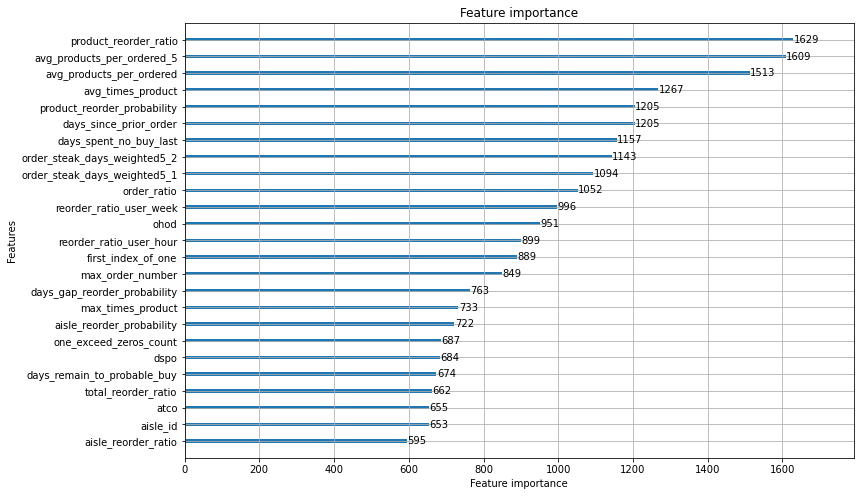

In [115]:
lightgbm.plot_importance(clf_lgb,max_num_features=25,figsize=(12,8))

#### F1 Score calculation

### Calculating f1 score based on diffferent probability threshold

In [11]:
y_pred_proba = cab_cfl.predict_proba(x_test)

In [18]:
threshold = [0.1,0.2,0.3,0.4,0.5]

In [19]:
threshold = [0.1,0.2,0.3,0.4,0.5]
y_pred_of_pred=[]
for i in threshold:
    y_pred=[]
    for j in range(len(y_pred_proba)):
        if(y_pred_proba[j][1]>i):
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred_of_pred.append(y_pred)

### 0.2 found to be the best threshold

##### Preparing data format  for kaggle competion (this f1 score we will specifically use in kaggle , not applicable to real world ), For real world seperate f1 score is calculated

In [5]:
pred_true_data=pd.read_csv('pred_true_data.csv')

In [6]:
temp_test_order_id=pd.unique(pred_true_data['order_id'])
f_test_pro=dict()
f_pred_proba=dict()
f_pred_products=dict()
for oid in tqdm(temp_test_order_id):
    
    temp_data=pred_true_data[pred_true_data['order_id']==oid]
    temp_true=temp_data[temp_data['y_true']==1]['product_id'].tolist()
    if temp_true:
        f_test_pro[oid]=[str(i) for i in temp_true]
    else:
        f_test_pro[oid]=['None']
    
    temp_pred_list=temp_data['deep_proba'].tolist()
    products_proba =temp_data['product_id'].tolist()
    f_pred_proba[oid]    = [round(i,4) for i in temp_pred_list]
    f_pred_products[oid] = products_proba
    
pred_list=dict()
for oid in tqdm(temp_test_order_id):
    a=get_best_prediction(f_pred_products[oid],f_pred_proba[oid])
    pred_list[oid]=a
#f_score=[]
#for key in tqdm(f_test_pro):
#    f_score.append(multilabel_fscore(f_test_pro[key],pred_list[key].split(' ')))

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

In [9]:
f_score=[]
for key in tqdm(f_test_pro):
    f_score.append(multilabel_fscore(f_test_pro[key],pred_list[key].split(' ')))

  0%|          | 0/39526 [00:00<?, ?it/s]

In [10]:
np.mean(f_score)

0.3958229723841579

In [45]:
micro_f1_score,macro_f1_score = measure_best_F1_score(y_pred_proba)

print('lightgbm Micro_f1_score is: ',micro_f1_score)
print('lightgbm Macro_f1_score is: ',macro_f1_score)

  0%|          | 0/39526 [00:00<?, ?it/s]

  0%|          | 0/39526 [00:00<?, ?it/s]

lightgbm Micro_f1_score is:  0.37414362993378963
lightgbm Macro_f1_score is:  0.45564490043210404


#### Kaggle related code ends here

### Final score table with different hypertuned models and for best probability threshold of 0.2

In [49]:
#credits: https://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "micro_f1_score", "macro_f1_score"]

x.add_row(["Logistic Regression_balanced", 0.3714, 0.4379])
x.add_row(["Linear SVM_class_balanced", 0.3674, 0.4452])
x.add_row(["Naive Baye's class balanced ", 0.3092, 0.3997])
x.add_row(["Naive Baye's class balanced calibrated", 0.21, 0.27])
x.add_row(["Random Forest", 0.37007, 0.4297])
x.add_row(["Random Forest_class_balanced", 0.3781, 0.4578])
x.add_row(["Xgboost", 0.3685, 0.4268])
x.add_row(["Xgboost_class_balanced",0.3779 ,0.4561])
x.add_row(["lightgbm", 0.3707, 0.428])
x.add_row(["lightgbm_class_balanced",0.3796,0.4572])
x.add_row(["average_probability_models",0.3806,0.4579])

print(x)

+----------------------------------------+----------------+----------------+
|               Model Name               | micro_f1_score | macro_f1_score |
+----------------------------------------+----------------+----------------+
|      Logistic Regression_balanced      |     0.3714     |     0.4379     |
|       Linear SVM_class_balanced        |     0.3674     |     0.4452     |
|      Naive Baye's class balanced       |     0.3092     |     0.3997     |
| Naive Baye's class balanced calibrated |      0.21      |      0.27      |
|             Random Forest              |    0.37007     |     0.4297     |
|      Random Forest_class_balanced      |     0.3781     |     0.4578     |
|                Xgboost                 |     0.3685     |     0.4268     |
|         Xgboost_class_balanced         |     0.3779     |     0.4561     |
|                lightgbm                |     0.3707     |     0.428      |
|        lightgbm_class_balanced         |     0.3796     |     0.4572     |

Note<br>

<ol>micro_f1_score:Here I calculated f1_scores for each user product list and took average across all users.(This will be used in kaggle)
macro_f1_score:Here I calculated f1_scores for each user product list and taking weighted average of products with each user.</ol>

### Procedure
<ol>
 <li>After EDA I processed the data . Only 'days_since_prior_order' had null values. Took care of it while featurizing . There were no outliers or missing values .Data was clean with every other aspects. Combined prior data with training data for creating training label.After featurizing found that 'reordered data' is much lower than 'not reordered data'. So there was data imbalance. Took care of this issue while creating models.</li>
<li>Tried linear classification techniques like logistic regression , linear svm with hypertuning and found the f1_scores. Data imbalance issue was taken care.</li>
<li>Tried non linear classification techniques like naive baye's, random forest,xgboost and lightgbm with hypertuning and found the f1_scores. F1 scores with class balanced and not balanced found out.Data balancing improved the performance</li>
 <li>random forest , xgboost, lightgbm performed and scores were very close. Logistic regression and linear svm scores were very competitive to these advanced non_linear methods. Naive baye's was the worst performer</li>
 <li>random forest , xgboost, lightgbm performed and scores were very close. Logistic regression and linear svm scores were very competitive to these advanced non_linear methods. Naive baye's was the worst performer</li>
 <li>I checked the accuracy of the models for different probability thresholds , o.2 found to be the best threshold</li> 
 <li>Highest score recorded was for lightgbm with 0.3796 micro_f1 score and 0.4572 macro_f1 score</li>
 <li>Feature importance graph is plotted for lightgbm , just to check important features</li>
 <li>Then took average probabilities of 4 top performed models and calculated the scores again . This time micro and macro f1 scores of 0.3806 and 0.4579 was obtained</li>
</ol>

###### Final top scores

In [2]:
final_data_scores=pd.read_csv('final_data_scores.csv')

In [4]:
final_data_scores[['model','micro_f1_score','macro_f1_score','F1_maximization_technique(for kaggle)']]

,model,micro_f1_score,macro_f1_score,F1_maximization_technique(for kaggle)
0,logistic_Regression,0.3713,0.4379,0.381847
1,light_gbm_class_weight_balanced,0.3797,0.4572,0.393008
2,Random_Forest_class_weight_balanced,0.3781,0.4579,0.386002
3,xgboost_class_weight_balanced,0.3779,0.4561,0.388542
4,avgProbability_xrl,0.3799,0.4588,0.390651
5,avgProbability_lxrl,0.3806,0.4579,0.390948


#### Micro and macro f1 scores are applicable to real world scoring . Here I used a special technique called F1_score_maximization technique. This will be used to boost the kaggle score.

##### Highest F1_score calculated with F1_score_maximization technique is <font color='red'>0.3930</font>, which is my probable kaggle score

#### Kaggle scorecard screenshot of different models

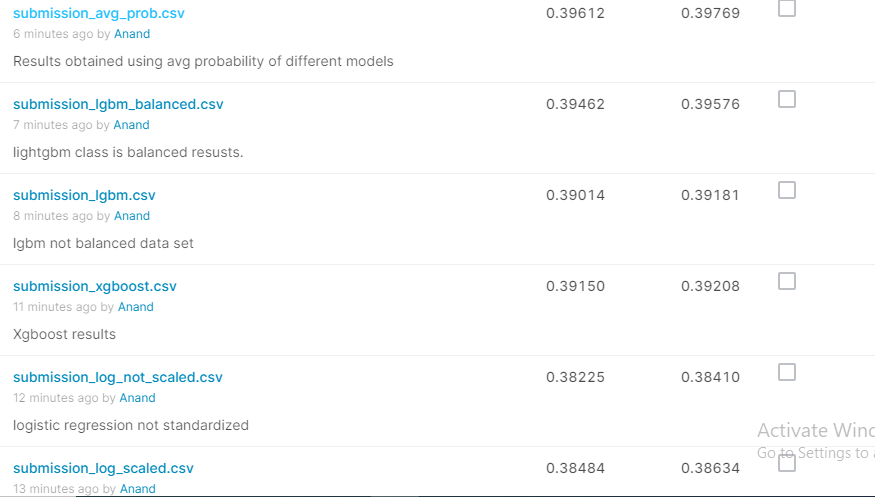

In [3]:
#https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o
from IPython.display import Image
Image("kaggleresult1.PNG")


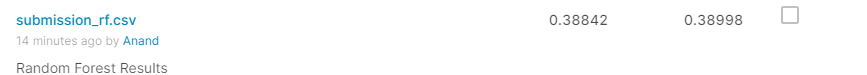

In [5]:
Image("kaggleresult2.PNG")

### Highest public board score achieved is 0.39769 and 0.39612 for private board
### Highest accuracy obtained for average probability of prediction for reorder across different models